# <font color='red'> Spoken Digit Recognition</font>

# Problem statement
- Given audio of pronouncing any one of the 10 digits(0-9), we need to recognise that correctly...
- we are going to build 4 different models in which each has different featurisation of data with LSTM in it...

- Model 1-Raw Data
- Model 2-Spectrogram
- Model 3-Raw Data with Data Augmentation
- Model 4-Spectrogram with Data Augmentation


In [13]:
import numpy as np
import pandas as pd
import librosa
import os
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Upload a file
'''from google.colab import files
uploaded = files.upload()'''


'from google.colab import files\nuploaded = files.upload()'

In [ ]:
# mounted my Google Drive in colab
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

We shared recordings.zip, please unzip those. 

In [ ]:
#read the all file names in the recordings folder given by us
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"
!unzip recordings.zip

Archive:  recordings.zip
   creating: recordings/
  inflating: recordings/0_jackson_0.wav  
  inflating: recordings/0_jackson_1.wav  
  inflating: recordings/0_jackson_10.wav  
  inflating: recordings/0_jackson_11.wav  
  inflating: recordings/0_jackson_12.wav  
  inflating: recordings/0_jackson_13.wav  
  inflating: recordings/0_jackson_14.wav  
  inflating: recordings/0_jackson_15.wav  
  inflating: recordings/0_jackson_16.wav  
  inflating: recordings/0_jackson_17.wav  
  inflating: recordings/0_jackson_18.wav  
  inflating: recordings/0_jackson_19.wav  
  inflating: recordings/0_jackson_2.wav  
  inflating: recordings/0_jackson_20.wav  
  inflating: recordings/0_jackson_21.wav  
  inflating: recordings/0_jackson_22.wav  
  inflating: recordings/0_jackson_23.wav  
  inflating: recordings/0_jackson_24.wav  
  inflating: recordings/0_jackson_25.wav  
  inflating: recordings/0_jackson_26.wav  
  inflating: recordings/0_jackson_27.wav  
  inflating: recordings/0_jackson_28.wav  
  infla

In [14]:
all_files = os.listdir('recordings')


Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

In [16]:
df_audio = pd.DataFrame()
df_audio['path'] = ['recordings/' + ele for ele in all_files]
df_audio['label'] = [ele.split('_')[0] for ele in all_files]

In [ ]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [ ]:
df_audio.head(5)

,path,label
0,recordings/8_theo_7.wav,8
1,recordings/7_nicolas_12.wav,7
2,recordings/8_nicolas_10.wav,8
3,recordings/9_nicolas_45.wav,9
4,recordings/4_theo_32.wav,4


## Exploring the sound dataset

In [ ]:
#It is a good programming practise to explore the dataset that you are dealing with. This dataset is unique in itself because it has sounds as input
#https://colab.research.google.com/github/Tyler-Hilbert/AudioProcessingInPythonWorkshop/blob/master/AudioProcessingInPython.ipynb
#visualize the data and write code to play 2-3 sound samples in the notebook for better understanding.
#please go through the following reference video https://www.youtube.com/watch?v=37zCgCdV468

!git clone https://github.com/AllenDowney/ThinkDSP.git 

Cloning into 'ThinkDSP'...
remote: Enumerating objects: 2469, done.
remote: Total 2469 (delta 0), reused 0 (delta 0), pack-reused 2469
Receiving objects: 100% (2469/2469), 208.82 MiB | 22.03 MiB/s, done.
Resolving deltas: 100% (1353/1353), done.


# <font color='red'>In the spectrogram view, the vertical axis displays frequency in Hertz, the horizontal axis represents time (just like the waveform display), and amplitude is represented by brightness.  </font>

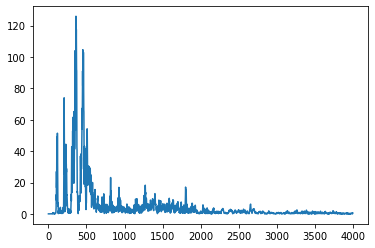

Writing sound.wav


In [ ]:
import sys
sys.path.insert(0, './ThinkDSP/code/') 
import thinkdsp
import matplotlib.pyplot as pyplot
import IPython

# Read in audio file
# FIXME - will this work for non wav files
wave = thinkdsp.read_wave("/content/recordings/0_jackson_0.wav")


# Plot spectrum of audio file
spectrum = wave.make_spectrum()
spectrum.plot()
pyplot.show()

# Play audio file
wave.play()
IPython.display.Audio('sound.wav')

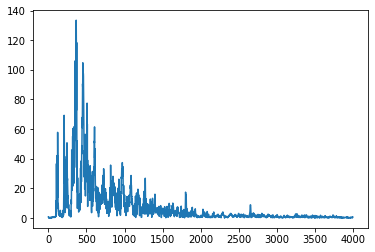

Writing sound.wav


/content/./ThinkDSP/code/thinkdsp.py:1173: UserWarning: Warning: normalizing before quantizing.
  warnings.warn("Warning: normalizing before quantizing.")


In [ ]:
import sys
sys.path.insert(0, './ThinkDSP/code/') 
import thinkdsp
import matplotlib.pyplot as pyplot
import IPython

# Read in audio file
# FIXME - will this work for non wav files 
wave1 = thinkdsp.read_wave("/content/recordings/0_jackson_0.wav")    
wave2 = thinkdsp.read_wave("/content/recordings/1_yweweler_29.wav")

wave=wave1+wave2           #combining two audio

# Plot spectrum of audio file
spectrum = wave.make_spectrum()
spectrum.plot()
pyplot.show()

# Play audio file
wave.play()
IPython.display.Audio('sound.wav')

## Creating dataframe

In [ ]:
#Create a dataframe(name=df_audio) with two columns(path, label).   
#You can get the label from the first letter of name.  
#Eg: 0_jackson_0 --> 0  
#0_jackson_43 --> 0


In [ ]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [17]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [18]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%
X_train, X_test, y_train, y_test = train_test_split(df_audio.path, df_audio.label,
                                                    test_size = 0.3, random_state = 45, 
                                                    stratify = df_audio.label)

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [19]:
sample_rate = 22050   #While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return [samples, duration]
    else:
        return samples

In [20]:
#use load_wav function that was written above to get every wave. 
#save it in X_train_processed and X_test_processed
# X_train_processed/X_test_processed should be dataframes with two columns(raw_data, duration) with same index of X_train/y_train
samples_train, samples_test, durations_train, durations_test = [],[],[],[]

for ele in X_train.values:
    samples, duration = load_wav(ele)
    samples_train.append(samples)
    durations_train.append(duration)

for ele in X_test.values:
    samples, duration = load_wav(ele)
    samples_test.append(samples)
    durations_test.append(duration)

X_train_processed = pd.DataFrame({'raw_data' : samples_train, 'duration' : durations_train})
X_test_processed = pd.DataFrame({'raw_data' : samples_test, 'duration' : durations_test})

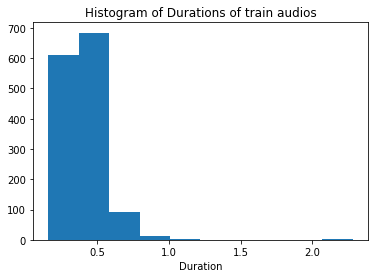

In [ ]:
#plot the histogram of the duration for train
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(X_train_processed.duration)
plt.xlabel('Duration')
plt.title('Histogram of Durations of train audios')
plt.show()

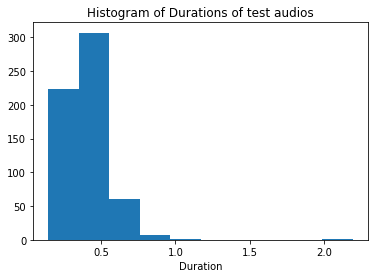

In [ ]:
#plot the histogram of the duration for test
plt.hist(X_test_processed.duration)
plt.xlabel('Duration')
plt.title('Histogram of Durations of test audios')
plt.show()

In [ ]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 
for i in range(0,11,1):
    print(f"{i*10}th percentile is {np.percentile(X_train_processed.duration.values, i*10)}")

0th percentile is 0.1564172335600907
10th percentile is 0.25989569160997733
20th percentile is 0.29872108843537415
30th percentile is 0.33277097505668934
40th percentile is 0.359718820861678
50th percentile is 0.3898185941043084
60th percentile is 0.4171156462585034
70th percentile is 0.44616780045351473
80th percentile is 0.48358276643990933
90th percentile is 0.5447165532879821
100th percentile is 2.282766439909297


In [ ]:
##print 90 to 100 percentile values with step size of 1. 
for i in range(0,11,1):
    print(f"{i+90}th percentile is {np.percentile(X_train_processed.duration.values, i+90)}")

90th percentile is 0.5447165532879821
91th percentile is 0.5635020408163269
92th percentile is 0.5778757369614513
93th percentile is 0.5933292517006804
94th percentile is 0.610172335600907
95th percentile is 0.6227800453514739
96th percentile is 0.6430421768707484
97th percentile is 0.66358231292517
98th percentile is 0.6925750566893424
99th percentile is 0.7906811791383219
100th percentile is 2.282766439909297


<b>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset.</b>

<b>While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640
</b>
<b>Pad with Zero if length of sequence is less than 17640 else Truncate the number. </b>

<b> Also create a masking vector for train and test. </b>

<b> masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.</b>


In [21]:
max_length  = 17640

X_train_pad_seq = pad_sequences(X_train_processed.raw_data, 
                                maxlen = max_length, 
                                padding = 'post',
                                dtype = 'float32',
                                truncating = 'post')

X_test_pad_seq = pad_sequences(X_test_processed.raw_data, 
                               maxlen = max_length,
                               padding = 'post',
                               dtype = 'float64',
                               truncating = 'post')



In [22]:
X_train_mask = X_train_pad_seq != 0
X_test_mask = X_test_pad_seq != 0


In [23]:
X_train_pad_seq = np.expand_dims(X_train_pad_seq, -1)
X_test_pad_seq = np.expand_dims(X_test_pad_seq, -1)

y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')

### 1. Giving Raw data directly. 


Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 




In [24]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

In [25]:
## as discussed above, please write the architecture of the model.
## you will have two input layers in your model (data input layer and mask input layer)
## make sure that you have defined the data type of masking layer as bool
class F1ScoreCB(tf.keras.callbacks.Callback):
    def __init__(self, train_data, test_data):
        super().__init__()
        self.train_data = train_data
        self.test_data = test_data
        self.history = {}
        self.history['val_f1_score'] = []
    
  
    def on_epoch_end(self, epochs, logs = {}):
        train_preds = np.argmax(self.model.predict(self.train_data[0]), axis = -1)
        train_f1_score = f1_score(self.train_data[1], train_preds, average='micro')
        train_f1_score = np.round(train_f1_score, 4)

        test_preds = np.argmax(self.model.predict(self.test_data[0]), axis = -1)
        test_f1_score = f1_score(self.test_data[1], test_preds, average='micro')
        test_f1_score = np.round(test_f1_score, 4)
        self.history['val_f1_score'].append(test_f1_score)

        print(f" - f1_score: {train_f1_score} - val_f1_score: {test_f1_score}")

        writer1 = tf.summary.create_file_writer(logdir + '/train_f1_score')
        writer2 = tf.summary.create_file_writer(logdir + '/validation_f1_score')
        
        #writing to tensoboard
        with writer1.as_default():
            tf.summary.scalar('F1_Score', train_f1_score, step=epochs)
        writer1.flush()

        with writer2.as_default():
            tf.summary.scalar('F1_Score', test_f1_score, step=epochs)
        writer2.flush()









In [ ]:
#creating the first model
tf.keras.backend.clear_session()
inp = Input(shape = (17640,1))
x_mask = Input(shape = (17640), dtype = 'bool')
x = LSTM(25)(inp, mask = x_mask)
x = Dense(50, activation = 'relu', kernel_initializer = 'he_normal')(x)
out = Dense(10, activation = 'softmax', kernel_initializer = 'glorot_normal')(x)

model1 = Model(inputs = [inp, x_mask], outputs = out)
#printing the summary of model
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17640, 1)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 17640)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 25)           2700        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 50)           1300        ['lstm[0][0]']               

In [ ]:
#train your model
#model1.fit([X_train_pad_seq,X_train_mask],y_train_int,.........)

In [ ]:
#training the model
!rm -rf ./logs/
import datetime

logdir = os.path.join('/content/drive/MyDrive/spoken digit/logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))



In [ ]:
model1.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy')

cb = [tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1, write_graph = True),
      F1ScoreCB(([X_train_pad_seq, X_train_mask], y_train), ([X_test_pad_seq, X_test_mask], y_test)),
      tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.1, patience = 1)]

model1.fit([X_train_pad_seq, X_train_mask], y_train, validation_data = ([X_test_pad_seq, X_test_mask], y_test),
           batch_size = 8, epochs = 5, callbacks = cb)

Epoch 1/5
19/19 [==============================] - 4s 201ms/step
 - f1_score: 0.1 - val_f1_score: 0.1
175/175 [==============================] - 86s 475ms/step - loss: 2.3037 - val_loss: 2.3026
Epoch 2/5
19/19 [==============================] - 4s 206ms/step
 - f1_score: 0.1 - val_f1_score: 0.1033
175/175 [==============================] - 81s 463ms/step - loss: 2.3038 - val_loss: 2.3026


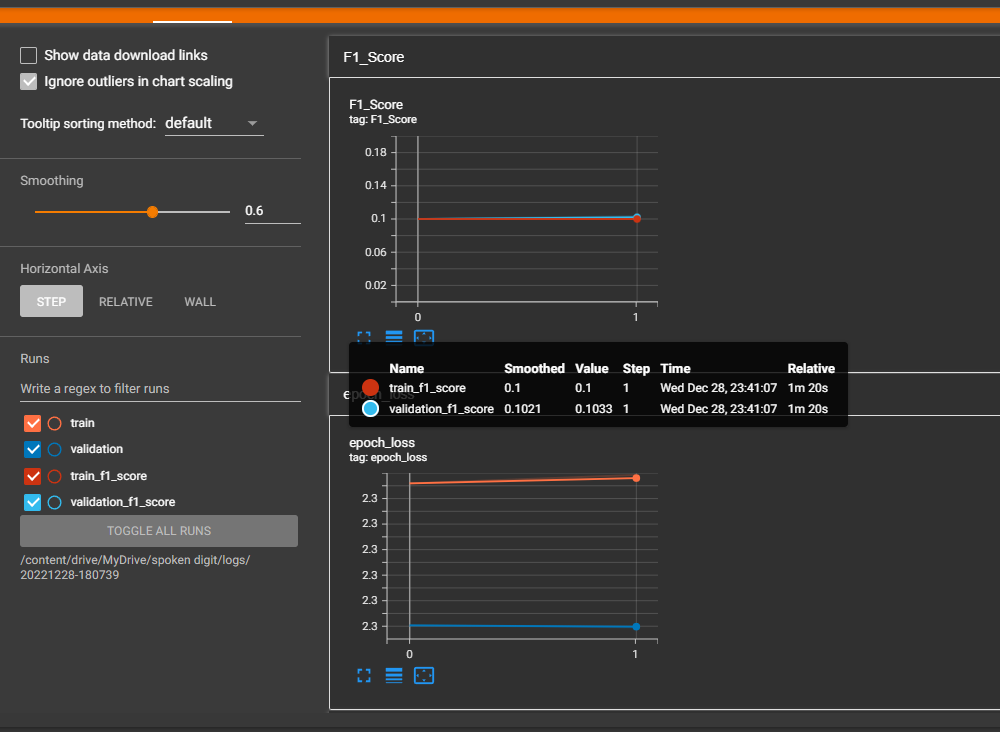

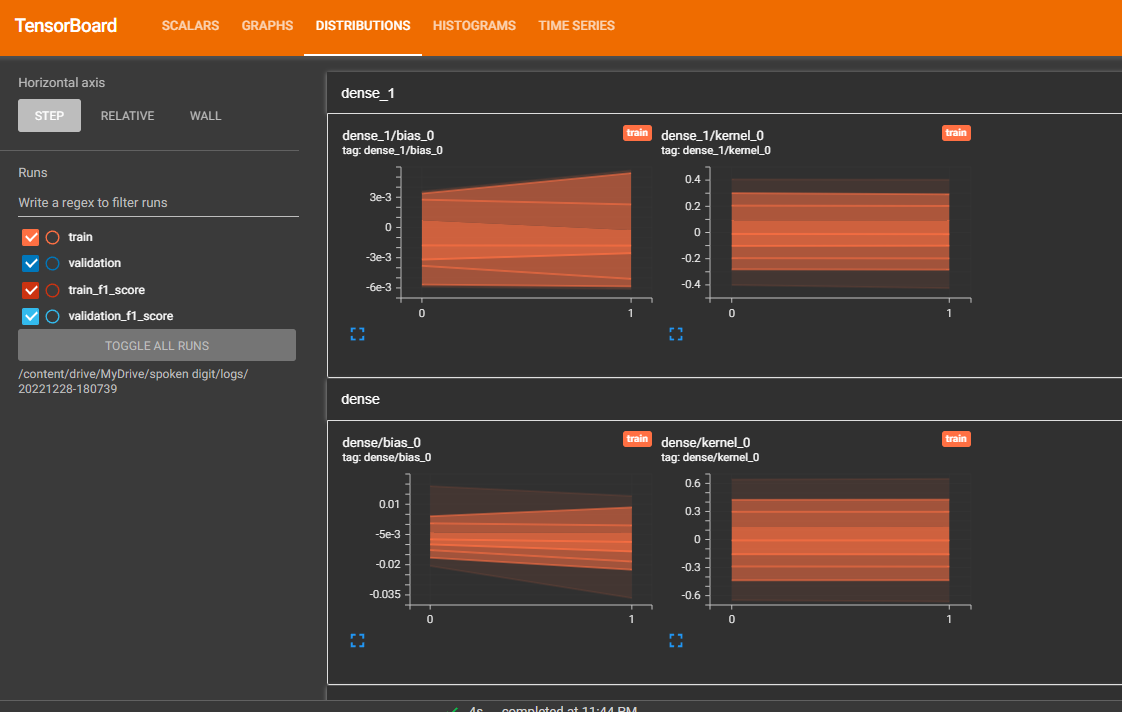

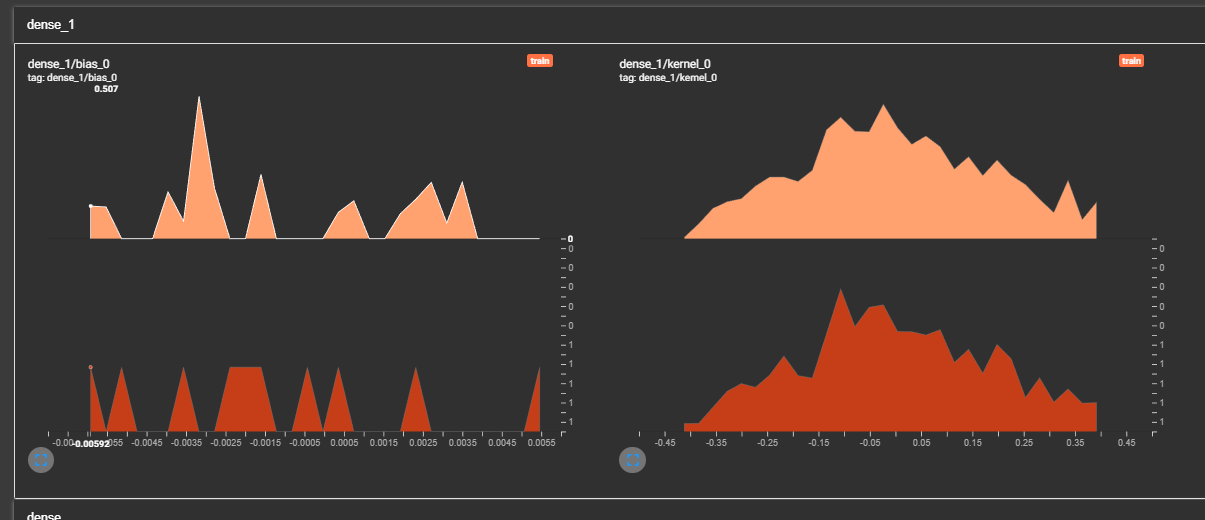

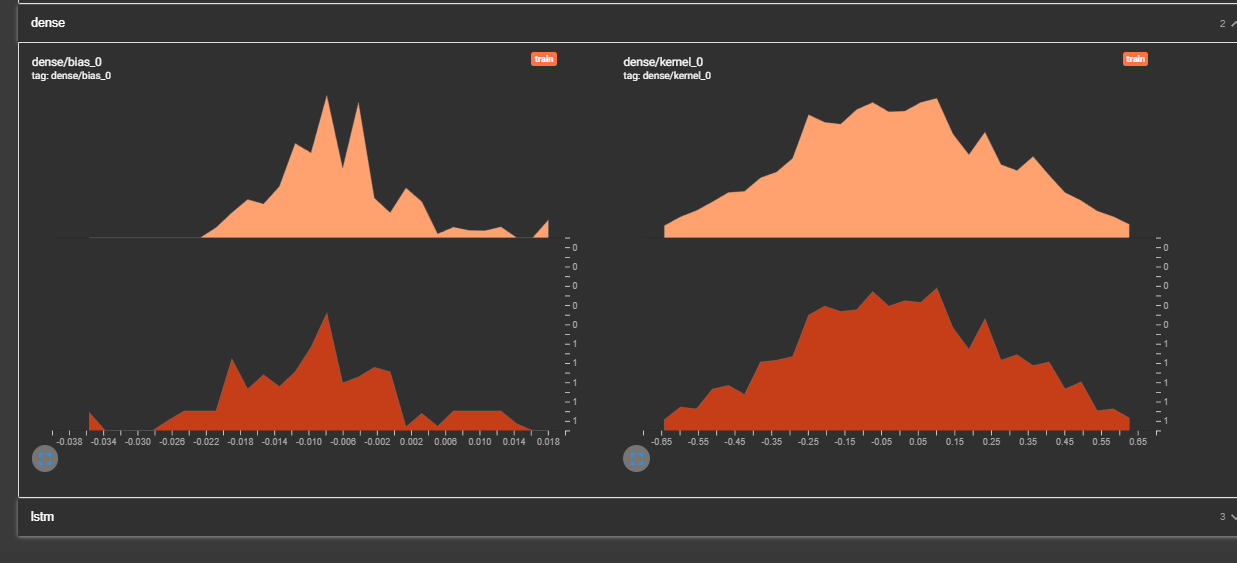

- <font color='blue'>We notice here that the model isn't able to make much sense of the raw data, and the performance also doesn't improve with epoch.</font>

### 2. Converting into spectrogram and giving spectrogram data as input  

We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram


In [26]:
#reducing the dimensions back
X_train_pad_seq = np.squeeze(X_train_pad_seq, axis = -1)
X_test_pad_seq = np.squeeze(X_test_pad_seq, axis = -1)

In [27]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [ ]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram = []
for ele in X_train_pad_seq:
    logmel = convert_to_spectrogram(ele)
    X_train_spectrogram.append(logmel)
X_train_spectrogram = np.array(X_train_spectrogram)

X_test_spectrogram = []
for ele in X_test_pad_seq:
    logmel = convert_to_spectrogram(ele)
    X_test_spectrogram.append(logmel)
X_test_spectrogram = np.array(X_test_spectrogram)


Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 


In [ ]:
# write the architecture of the model
#print model.summary and make sure that it is following point 2 mentioned above

tf.keras.backend.clear_session()
inp = Input(shape = (64,35,))
x = LSTM(256, return_sequences = True)(inp)
print(x.shape)
x = tf.math.reduce_mean(x, axis = -1)
print(x.shape)
x = Dense(256, activation = 'relu', kernel_initializer = 'he_normal')(x)
out = Dense(10, activation = 'softmax', kernel_initializer = 'glorot_normal')(x)

model2 = Model(inputs = inp, outputs = out)
#printing the model summary
model2.summary()

(None, 64, 256)
(None, 64)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 256)           299008    
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 64)               0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 318,218
Trainable params: 318,218
Non-trainable params: 0
____________________________

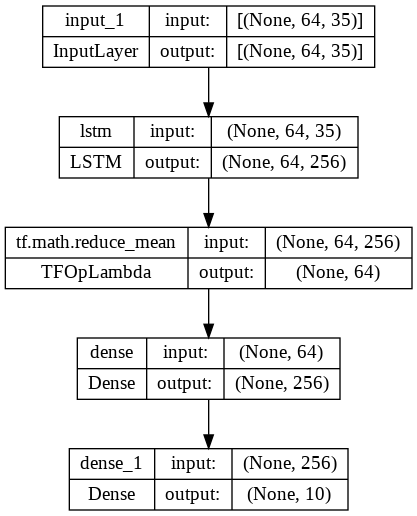

In [ ]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='/content/drive/MyDrive/spoken digit/model2.png', show_shapes=True, show_layer_names=True)

In [ ]:
#train your model
!rm -rf ./logs/
import datetime

logdir = os.path.join('/content/drive/MyDrive/spoken digit/logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))


In [ ]:
model2.compile(optimizer = tf.keras.optimizers.Adam(0.0005), loss = 'sparse_categorical_crossentropy')
cb = [tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1, write_graph = True),
      F1ScoreCB((X_train_spectrogram, y_train), (X_test_spectrogram, y_test)),
      tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.05, patience = 2)]

model2.fit(X_train_spectrogram, y_train, validation_data = (X_test_spectrogram, y_test),
           batch_size = 16, epochs = 15, callbacks = cb)

Epoch 1/15
 6/88 [=>............................] - ETA: 0s - loss: 2.3011  

19/19 [==============================] - 0s 4ms/step
 - f1_score: 0.3771 - val_f1_score: 0.3917
88/88 [==============================] - 4s 29ms/step - loss: 2.1883 - val_loss: 1.9001
Epoch 2/15
19/19 [==============================] - 0s 4ms/step
 - f1_score: 0.5214 - val_f1_score: 0.5683
88/88 [==============================] - 1s 16ms/step - loss: 1.6701 - val_loss: 1.4301
Epoch 3/15
19/19 [==============================] - 0s 4ms/step
 - f1_score: 0.6336 - val_f1_score: 0.6517
88/88 [==============================] - 1s 16ms/step - loss: 1.3372 - val_loss: 1.1689
Epoch 4/15
19/19 [==============================] - 0s 4ms/step
 - f1_score: 0.6407 - val_f1_score: 0.6633
88/88 [==============================] - 1s 15ms/step - loss: 1.1620 - val_loss: 1.0678
Epoch 5/15
19/19 [==============================] - 0s 4ms/step
 - f1_score: 0.6936 - val_f1_score: 0.7067
88/88 [==============================] - 1s 17ms/step - loss: 1.0085 - val_loss: 0.9280
Epoch 6/15
19/19 [==================

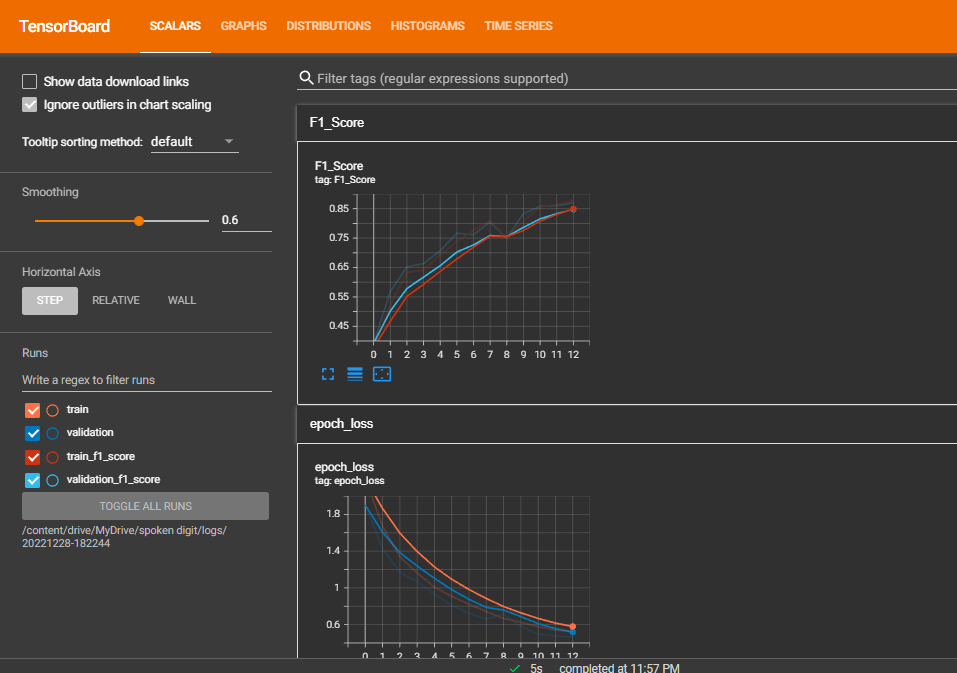

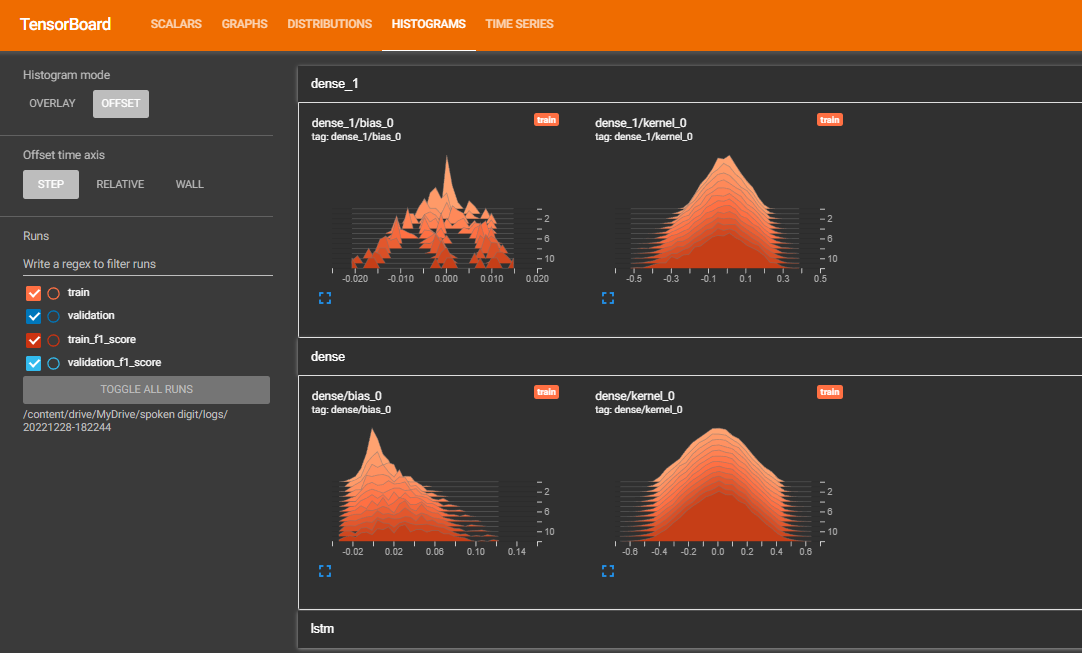

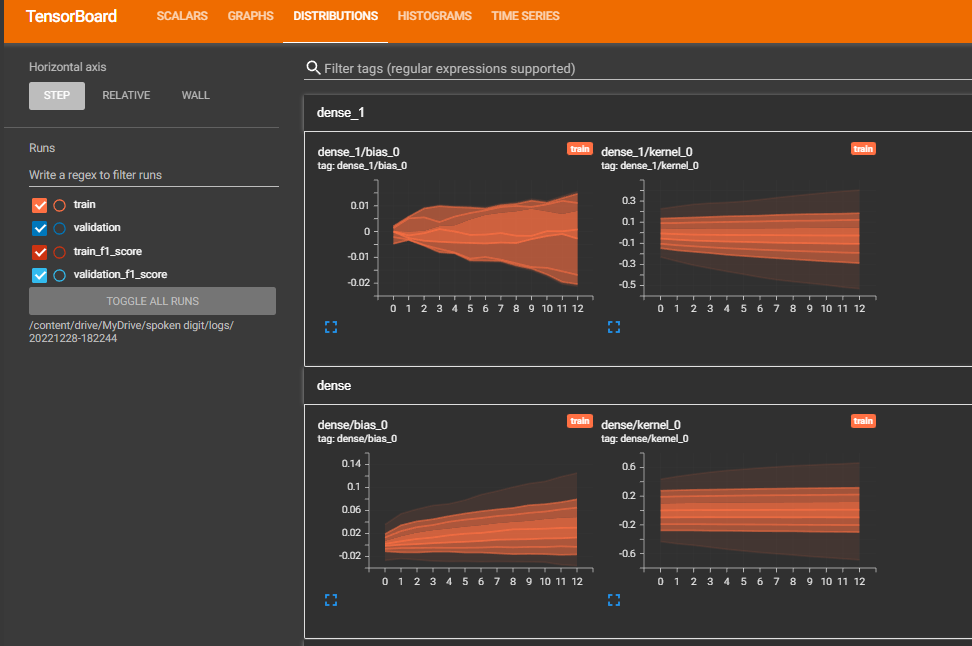

- <font color='blue'> Since spectogram featurisation captures freq-time-amp values, we  can see drastic improvement in the model</font>

### 3. Data augmentation with raw features 

Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.


In [28]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [ ]:
temp_path = df_audio.iloc[0].path
aug_temp = generate_augmented_data(temp_path)

In [ ]:
len(aug_temp)

9

In [30]:
X_train, X_test, y_train, y_test=train_test_split(df_audio['path'],df_audio['label'],random_state=45,test_size=0.2,stratify=df_audio['label'])

In [31]:
train_aug_data = []
train_labels = []

for path, label in zip(X_train.values, y_train.values):   #Do augmentation only on X_train
    aug_data = generate_augmented_data(path)
    train_aug_data.extend(aug_data)
    train_labels.extend(label*9)

X_train_processed = pd.DataFrame({'raw_data' : train_aug_data, 'label' : train_labels})

test_data = []
for path in X_test.values:
    test_data.append(load_wav(path, get_duration = False))

X_test_processed = pd.DataFrame({'raw_data' : test_data, 'label' : y_test.values})

In [ ]:
#X_train_processed.to_csv('X_train_processed.csv', index=False)
#X_test_processed.to_csv('X_test_processed.csv', index=False)

In [32]:
max_length  = 17640
#padding the sequences
X_train_pad_seq = pad_sequences(X_train_processed.raw_data, maxlen = max_length,
                                dtype = 'float32', padding = 'post', 
                                truncating = 'post')

X_test_pad_seq = pad_sequences(X_test_processed.raw_data, maxlen = max_length, 
                               dtype = 'float32', padding = 'post', 
                               truncating = 'post')

y_train = X_train_processed.label.values.astype('int')
y_test = X_test_processed.label.values.astype('int')

X_train_mask = X_train_pad_seq != 0
X_test_mask = X_test_pad_seq != 0

In [33]:
X_train_pad_seq = np.expand_dims(X_train_pad_seq, -1)
X_test_pad_seq = np.expand_dims(X_test_pad_seq, -1)

In [ ]:
tf.keras.backend.clear_session()
inp = Input(shape = (17640,1))
inp_mask = Input(shape = (17640), dtype = 'bool')

x = LSTM(25)(inp, mask = inp_mask)
x = Dense(50, activation = 'relu', kernel_initializer = 'he_normal')(x)
out = Dense(10, activation = 'softmax', kernel_initializer = 'glorot_normal')(x)

model3 = Model(inputs = [inp, inp_mask], outputs = out)

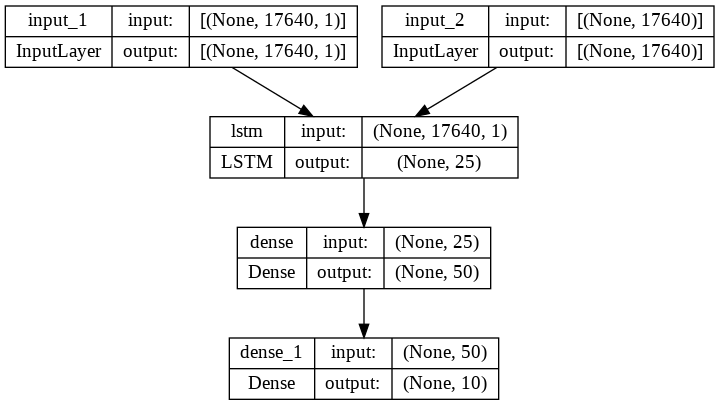

In [ ]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model3, to_file='/content/drive/MyDrive/spoken digit/model3.png', show_shapes=True, show_layer_names=True)

In [ ]:
model3.summary()
!rm -rf ./logs/
import datetime

logdir = os.path.join('/content/drive/MyDrive/spoken digit/logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17640, 1)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 17640)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 25)           2700        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 50)           1300        ['lstm[0][0]']               

In [ ]:
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
               loss = 'sparse_categorical_crossentropy')

cb = [tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_graph = True),
      tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.1, patience = 1),
      F1ScoreCB(([X_train_pad_seq, X_train_mask], y_train), ([X_test_pad_seq, X_test_mask], y_test))]

model3.fit([X_train_pad_seq, X_train_mask], y_train, validation_data = ([X_test_pad_seq, X_test_mask], y_test),
           epochs = 5, callbacks = cb, batch_size = 128)

Epoch 1/5
13/13 [==============================] - 4s 200ms/step
 - f1_score: 0.101 - val_f1_score: 0.0925
113/113 [==============================] - 220s 2s/step - loss: 2.3028 - val_loss: 2.3026
Epoch 2/5
13/13 [==============================] - 3s 196ms/step
 - f1_score: 0.1056 - val_f1_score: 0.1275
113/113 [==============================] - 218s 2s/step - loss: 2.3027 - val_loss: 2.3027


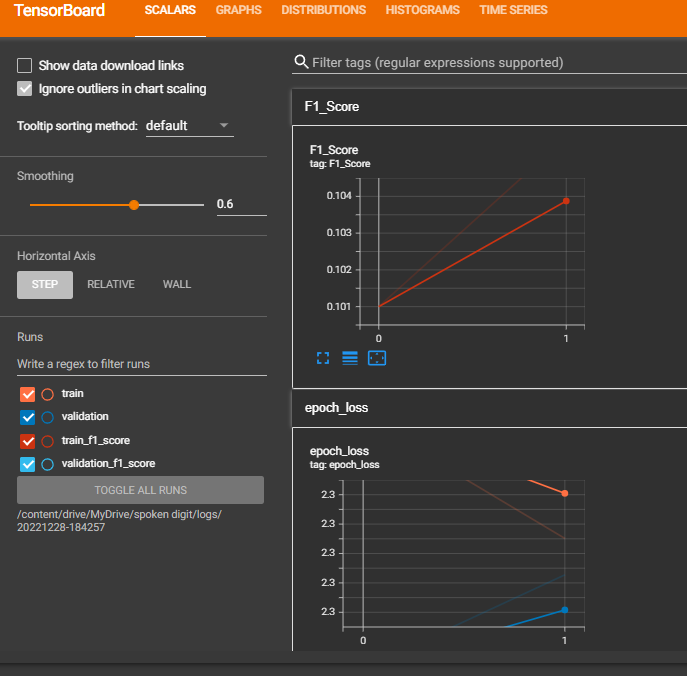

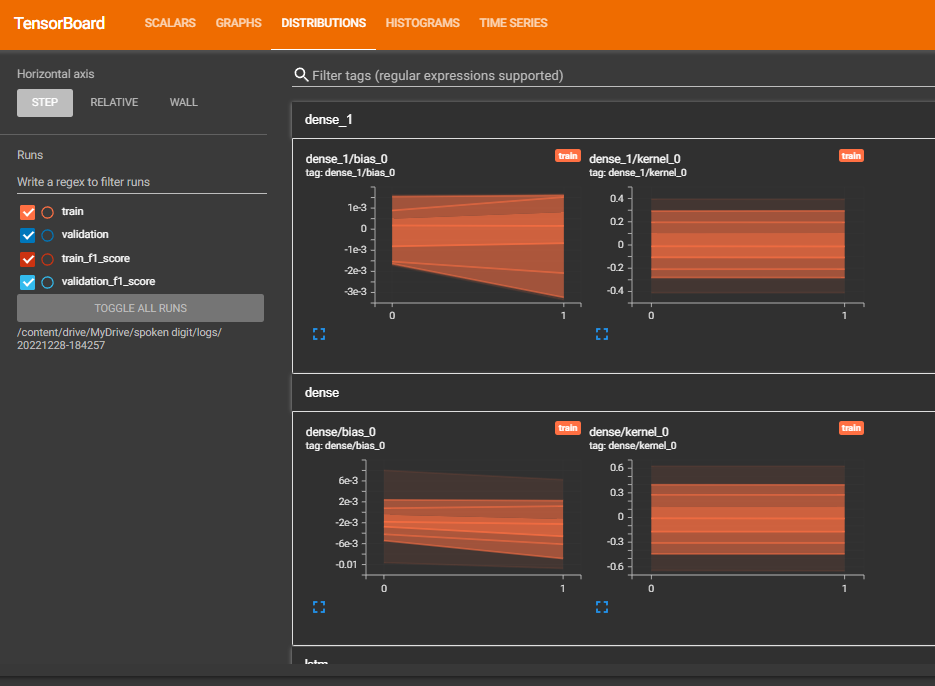

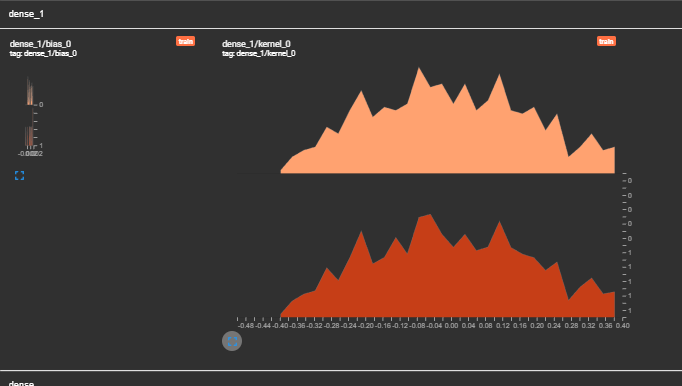

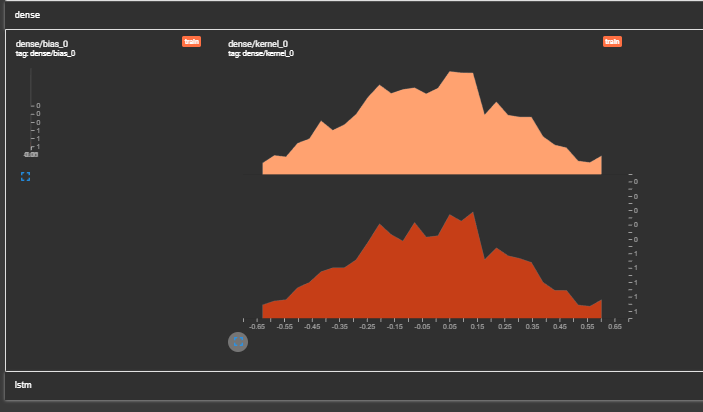

- <font color='blue'> Even thought data agumentation reduces overfitting, The lack of freq information in the raw data makes non good model and model does not learn very much from the raw data...</font>

### 4. Data augmentation with spectogram data

1. use convert_to_spectrogram and convert the padded data from train and test data to spectogram data.
2. The shape of train data will be 14400 x 64 x 35 and shape of test_data will be 400 x 64 x35
3. Define the model similar to model 2 and fit the data

In [35]:
X_train_spectrogram = []
for ele in X_train_pad_seq:
    logmel = convert_to_spectrogram(ele)
    X_train_spectrogram.append(logmel)
X_train_spectrogram = np.array(X_train_spectrogram)

X_test_spectrogram = []
for ele in X_test_pad_seq:
    logmel = convert_to_spectrogram(ele)
    X_test_spectrogram.append(logmel)
X_test_spectrogram = np.array(X_test_spectrogram)

In [36]:
tf.keras.backend.clear_session()
inp = Input(shape = (64,35,))
x = LSTM(256, return_sequences = True)(inp)
x = tf.math.reduce_mean(x, axis = -1)
x = Dense(256, activation = 'relu', kernel_initializer = 'he_normal')(x)
out = Dense(10, activation = 'softmax', kernel_initializer = 'glorot_normal')(x)

model4 = Model(inputs = inp, outputs = out)
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 256)           299008    
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 64)               0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 318,218
Trainable params: 318,218
Non-trainable params: 0
_______________________________________________________

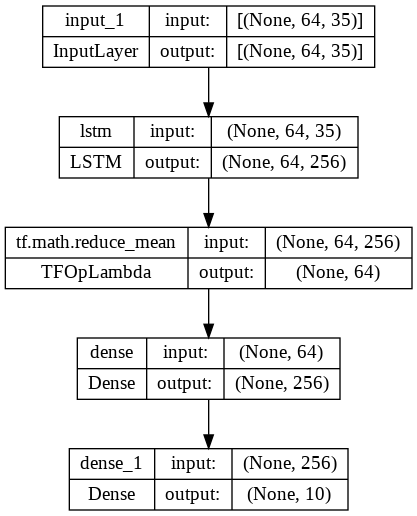

In [37]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model4, to_file='/content/drive/MyDrive/spoken digit/model4.png', show_shapes=True, show_layer_names=True)

In [38]:
#train your model
!rm -rf ./logs/
import datetime

logdir = os.path.join('/content/drive/MyDrive/spoken digit/logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [39]:
model4.compile(optimizer = tf.keras.optimizers.Adam(0.0005), loss = 'sparse_categorical_crossentropy')
cb = [tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1, write_graph = True),
      F1ScoreCB((X_train_spectrogram, y_train), (X_test_spectrogram, y_test)),
      tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.005, patience = 1)]

model4.fit(X_train_spectrogram, y_train, validation_data = (X_test_spectrogram, y_test),
           batch_size = 64, epochs = 15, callbacks = cb)

Epoch 1/15
  6/225 [..............................] - ETA: 2s - loss: 2.2987   

13/13 [==============================] - 0s 4ms/step
 - f1_score: 0.693 - val_f1_score: 0.6825
225/225 [==============================] - 9s 24ms/step - loss: 1.6082 - val_loss: 0.9360
Epoch 2/15
13/13 [==============================] - 0s 4ms/step
 - f1_score: 0.7963 - val_f1_score: 0.81
225/225 [==============================] - 4s 18ms/step - loss: 0.7817 - val_loss: 0.5570
Epoch 3/15
13/13 [==============================] - 0s 4ms/step
 - f1_score: 0.8437 - val_f1_score: 0.8675
225/225 [==============================] - 5s 21ms/step - loss: 0.5492 - val_loss: 0.4364
Epoch 4/15
13/13 [==============================] - 0s 4ms/step
 - f1_score: 0.8611 - val_f1_score: 0.84
225/225 [==============================] - 7s 30ms/step - loss: 0.4534 - val_loss: 0.4261
Epoch 5/15
13/13 [==============================] - 0s 4ms/step
 - f1_score: 0.8711 - val_f1_score: 0.84
225/225 [==============================] - 5s 21ms/step - loss: 0.3904 - val_loss: 0.3966
Epoch 6/15
13/13 [===============

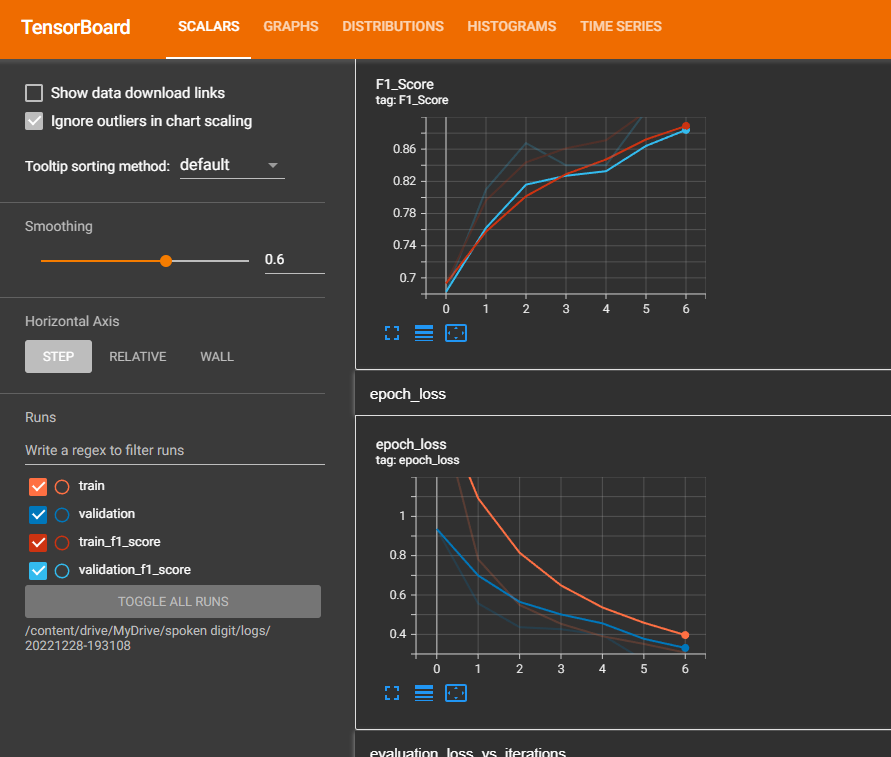

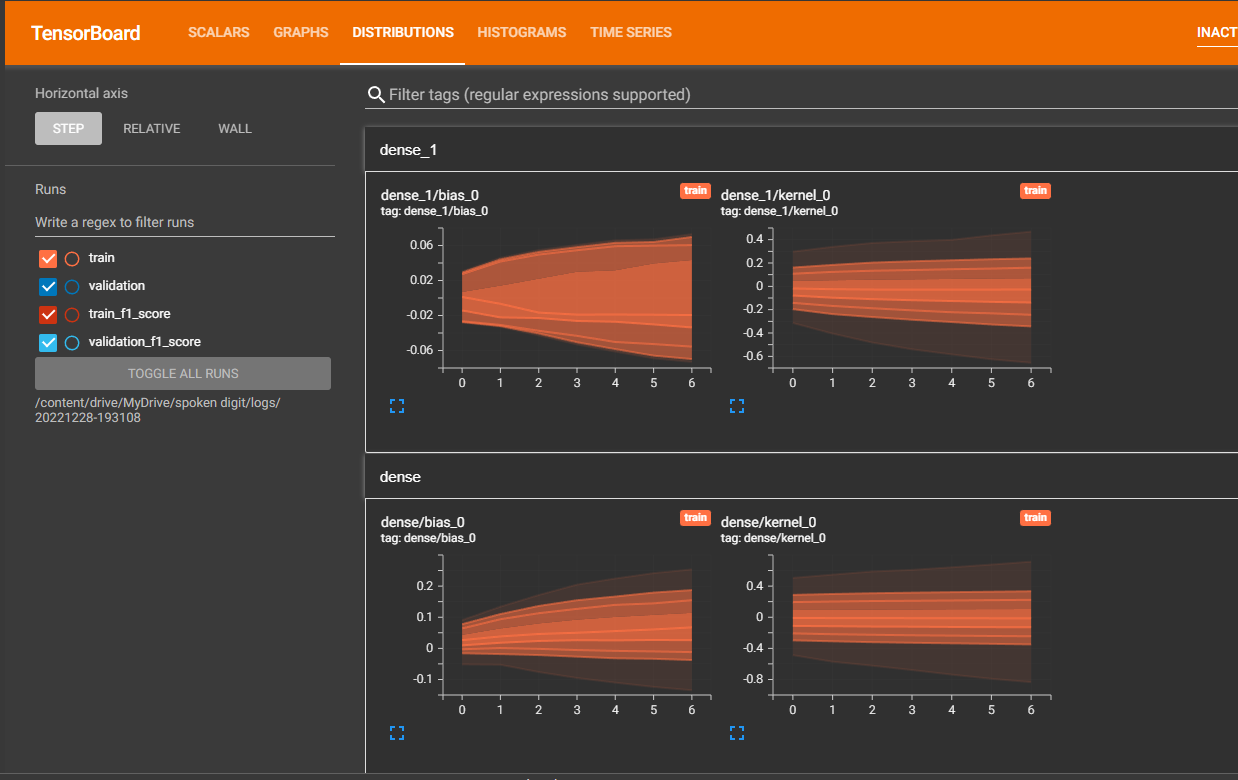

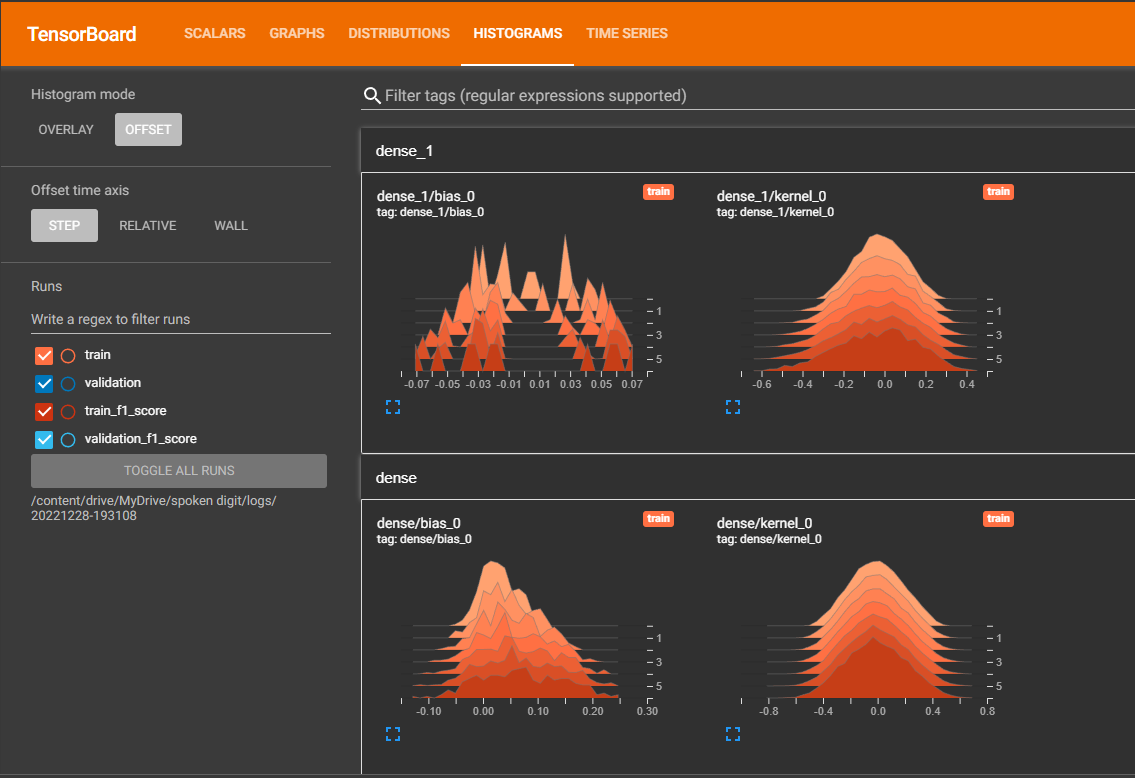

- <font color='blue'> Advantages of having freq-time-amp features in spectogram and reduction in overfitting by the data agumentation makes the model 4 to perform better than remaining 3 models</font>

# Summary

In [42]:
x = PrettyTable()
x.field_names = ['S. No.', 'Model', 'Train Loss', 'Val Loss', 'Train F1 Score', 'Val F1 Score']
x.add_row([1,'Raw Data', 2.3038, 2.3026, 0.1, 0.1033])
x.add_row([2, 'Spectrogram', 0.5249, 0.4618, 0.8771, 0.87])
x.add_row([3, 'Raw Data with Data Augmentation', 2.3027, 2.3027, 0.1056, 0.1275])
x.add_row([4, 'Spectrogram with Data Augmentation', 0.3069, 0.2648, 0.9131, 0.9125])
print(x)

+--------+------------------------------------+------------+----------+----------------+--------------+
| S. No. |               Model                | Train Loss | Val Loss | Train F1 Score | Val F1 Score |
+--------+------------------------------------+------------+----------+----------------+--------------+
|   1    |              Raw Data              |   2.3038   |  2.3026  |      0.1       |    0.1033    |
|   2    |            Spectrogram             |   0.5249   |  0.4618  |     0.8771     |     0.87     |
|   3    |  Raw Data with Data Augmentation   |   2.3027   |  2.3027  |     0.1056     |    0.1275    |
|   4    | Spectrogram with Data Augmentation |   0.3069   |  0.2648  |     0.9131     |    0.9125    |
+--------+------------------------------------+------------+----------+----------------+--------------+


- From the above results, we observe that Spectrograms give huge boost to performance as compared to Raw Audio Data. This is because Spectrograms capture the Time-Freq-Amplitude features of the given audios, while the Raw Data is just Amplitude-Time.
- Also data agumentation helps to have more train data which reduced the overfitting problem...